In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

def sensitivity_analysis_images(input_params, images, plot=True):
    """
    Perform sensitivity analysis directly on images as a function of input parameters.
    
    Parameters:
        input_params (numpy.ndarray): 1D array of input parameter values, shape (N,).
        images (numpy.ndarray): 3D array of images, shape (N, H, W).
        plot (bool): Whether to generate sensitivity heatmaps.
    
    Returns:
        dict: Results of the sensitivity analysis, including:
              - Trends: Array of slopes for the linear fit for each pixel.
              - R^2 scores: Goodness of fit for the trends.
              - Correlations: Pearson correlation coefficients for each pixel.
    """
    # Ensure input parameters are a 1D array
    input_params = np.array(input_params).reshape(-1, 1)
    
    # Extract dimensions
    N, H, W = images.shape
    
    # Flatten spatial dimensions for analysis
    pixel_values_flat = images.reshape(N, -1)  # Shape: (N, H*W)
    
    # Initialize arrays for trends, R^2 scores, and correlations
    trends = np.zeros(pixel_values_flat.shape[1])
    r2_scores = np.zeros(pixel_values_flat.shape[1])
    correlations = np.zeros(pixel_values_flat.shape[1])
    
    # Perform sensitivity analysis for each pixel
    for i in range(pixel_values_flat.shape[1]):
        y = pixel_values_flat[:, i]  # Pixel values across parameters
        
        # Fit a linear regression model
        reg = LinearRegression()
        reg.fit(input_params, y)
        y_pred = reg.predict(input_params)
        
        # Store the slope of the linear fit (trend)
        trends[i] = reg.coef_[0]
        
        # Compute goodness of fit (R^2 score)
        r2_scores[i] = r2_score(y, y_pred)
        
        # Compute Pearson correlation coefficient only if input is not constant
        if np.std(y) > 0:
            correlations[i], _ = pearsonr(input_params.flatten(), y)
        else:
            correlations[i] = np.nan  # Mark as undefined for constant inputs
    
    # Reshape results back to image shape
    trends = trends.reshape(H, W)
    r2_scores = r2_scores.reshape(H, W)
    correlations = correlations.reshape(H, W)
    
    # Plot results if required
    if plot:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        im1 = axes[0].imshow(trends, cmap="coolwarm", aspect="auto")
        axes[0].set_title("Pixel Sensitivity Trends (Slope)")
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(r2_scores, cmap="viridis", aspect="auto")
        axes[1].set_title("R^2 Scores (Goodness of Fit)")
        plt.colorbar(im2, ax=axes[1])

        im3 = axes[2].imshow(correlations, cmap="plasma", aspect="auto")
        axes[2].set_title("Pixel Correlations with Parameter")
        plt.colorbar(im3, ax=axes[2])

        plt.tight_layout()
        plt.show()
    
    # Return results
    return {
        "trends": trends,
        "r2_scores": r2_scores,
        "correlations": correlations,
    }


In [13]:
TV_ARCHIVE = np.load("TIK_RESIDUAL_Batch.npz")
TENSOR = np.zeros((len(TV_ARCHIVE), 256, 256), dtype=np.uint8)
PARAMS = np.zeros((512,1))

iterator = 0
for file in TV_ARCHIVE.files:
    arr = TV_ARCHIVE[file]
    TENSOR[iterator, :, :] = arr
    PARAMS[iterator] = float(file)
    iterator+=1

/tmp/ipykernel_363051/3485877971.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i], _ = pearsonr(input_params.flatten(), y)
/tmp/ipykernel_363051/3485877971.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i], _ = pearsonr(input_params.flatten(), y)
/tmp/ipykernel_363051/3485877971.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i], _ = pearsonr(input_params.flatten(), y)
/tmp/ipykernel_363051/3485877971.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i], _ = pearsonr(input_params.flatten(), y)
/tmp/ipykernel_363051/3485877971.py:52: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i], _ = pearsonr(input_params.flatten(), y)
/tmp/ipykernel_363051/3485877971.py

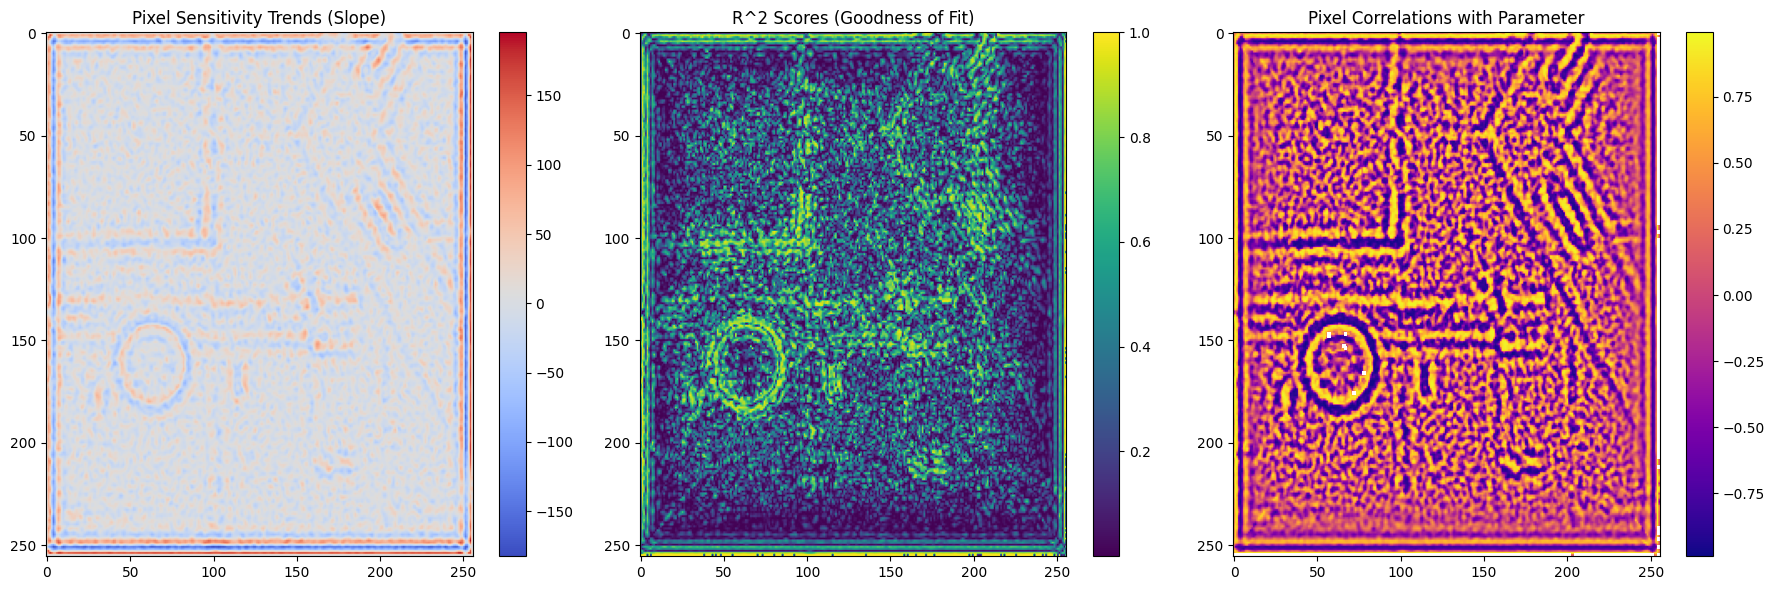

In [14]:
sensitivity_analysis_results = sensitivity_analysis_images(PARAMS, TENSOR, plot=True)

In [15]:
import numpy as np
from scipy.stats import norm

def compute_pixel_mean(image_stack):
    """
    Compute the pixel-wise mean of a stack of images.
    
    Parameters:
        image_stack (numpy.ndarray): 3D array of shape (256, 256, N) where N is the number of images.
        
    Returns:
        numpy.ndarray: 2D array of shape (256, 256) containing the pixel-wise mean.
    """
    return np.mean(image_stack, axis=2)

def compute_pixel_variance(image_stack):
    """
    Compute the pixel-wise variance of a stack of images.
    
    Parameters:
        image_stack (numpy.ndarray): 3D array of shape (256, 256, N) where N is the number of images.
        
    Returns:
        numpy.ndarray: 2D array of shape (256, 256) containing the pixel-wise variance.
    """
    return np.var(image_stack, axis=2)

def compute_pixel_confidence_intervals(image_stack, confidence_level=0.95):
    """
    Compute the pixel-wise confidence intervals for a stack of images.
    
    Parameters:
        image_stack (numpy.ndarray): 3D array of shape (256, 256, N) where N is the number of images.
        confidence_level (float): Confidence level for the intervals (default is 0.95).
        
    Returns:
        tuple of numpy.ndarray: Two 2D arrays of shape (256, 256) containing the lower and upper bounds of the confidence intervals.
    """
    # Compute mean and standard error for each pixel
    pixel_mean = compute_pixel_mean(image_stack)
    pixel_std = np.std(image_stack, axis=2, ddof=1)  # Unbiased estimate (ddof=1)
    n_samples = image_stack.shape[2]
    standard_error = pixel_std / np.sqrt(n_samples)
    
    # Compute z-score for the desired confidence level
    z_score = norm.ppf(0.5 + confidence_level / 2)
    
    # Compute confidence intervals
    lower_bound = pixel_mean - z_score * standard_error
    upper_bound = pixel_mean + z_score * standard_error
    
    return lower_bound, upper_bound


In [45]:
TV_ARCHIVE = np.load("VEGA_SSIM_TV_Batch.npz")
TENSOR = np.zeros((256,256,len(TV_ARCHIVE)), dtype=np.uint8)

iterator = 0
for file in TV_ARCHIVE.files:
    arr = TV_ARCHIVE[file]
    TENSOR[:, :, iterator] = arr
    iterator+=1

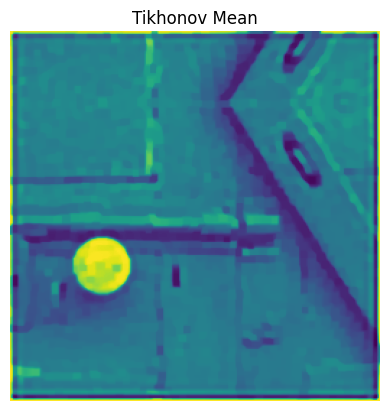

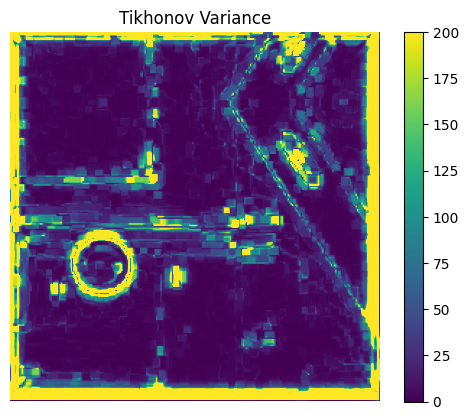

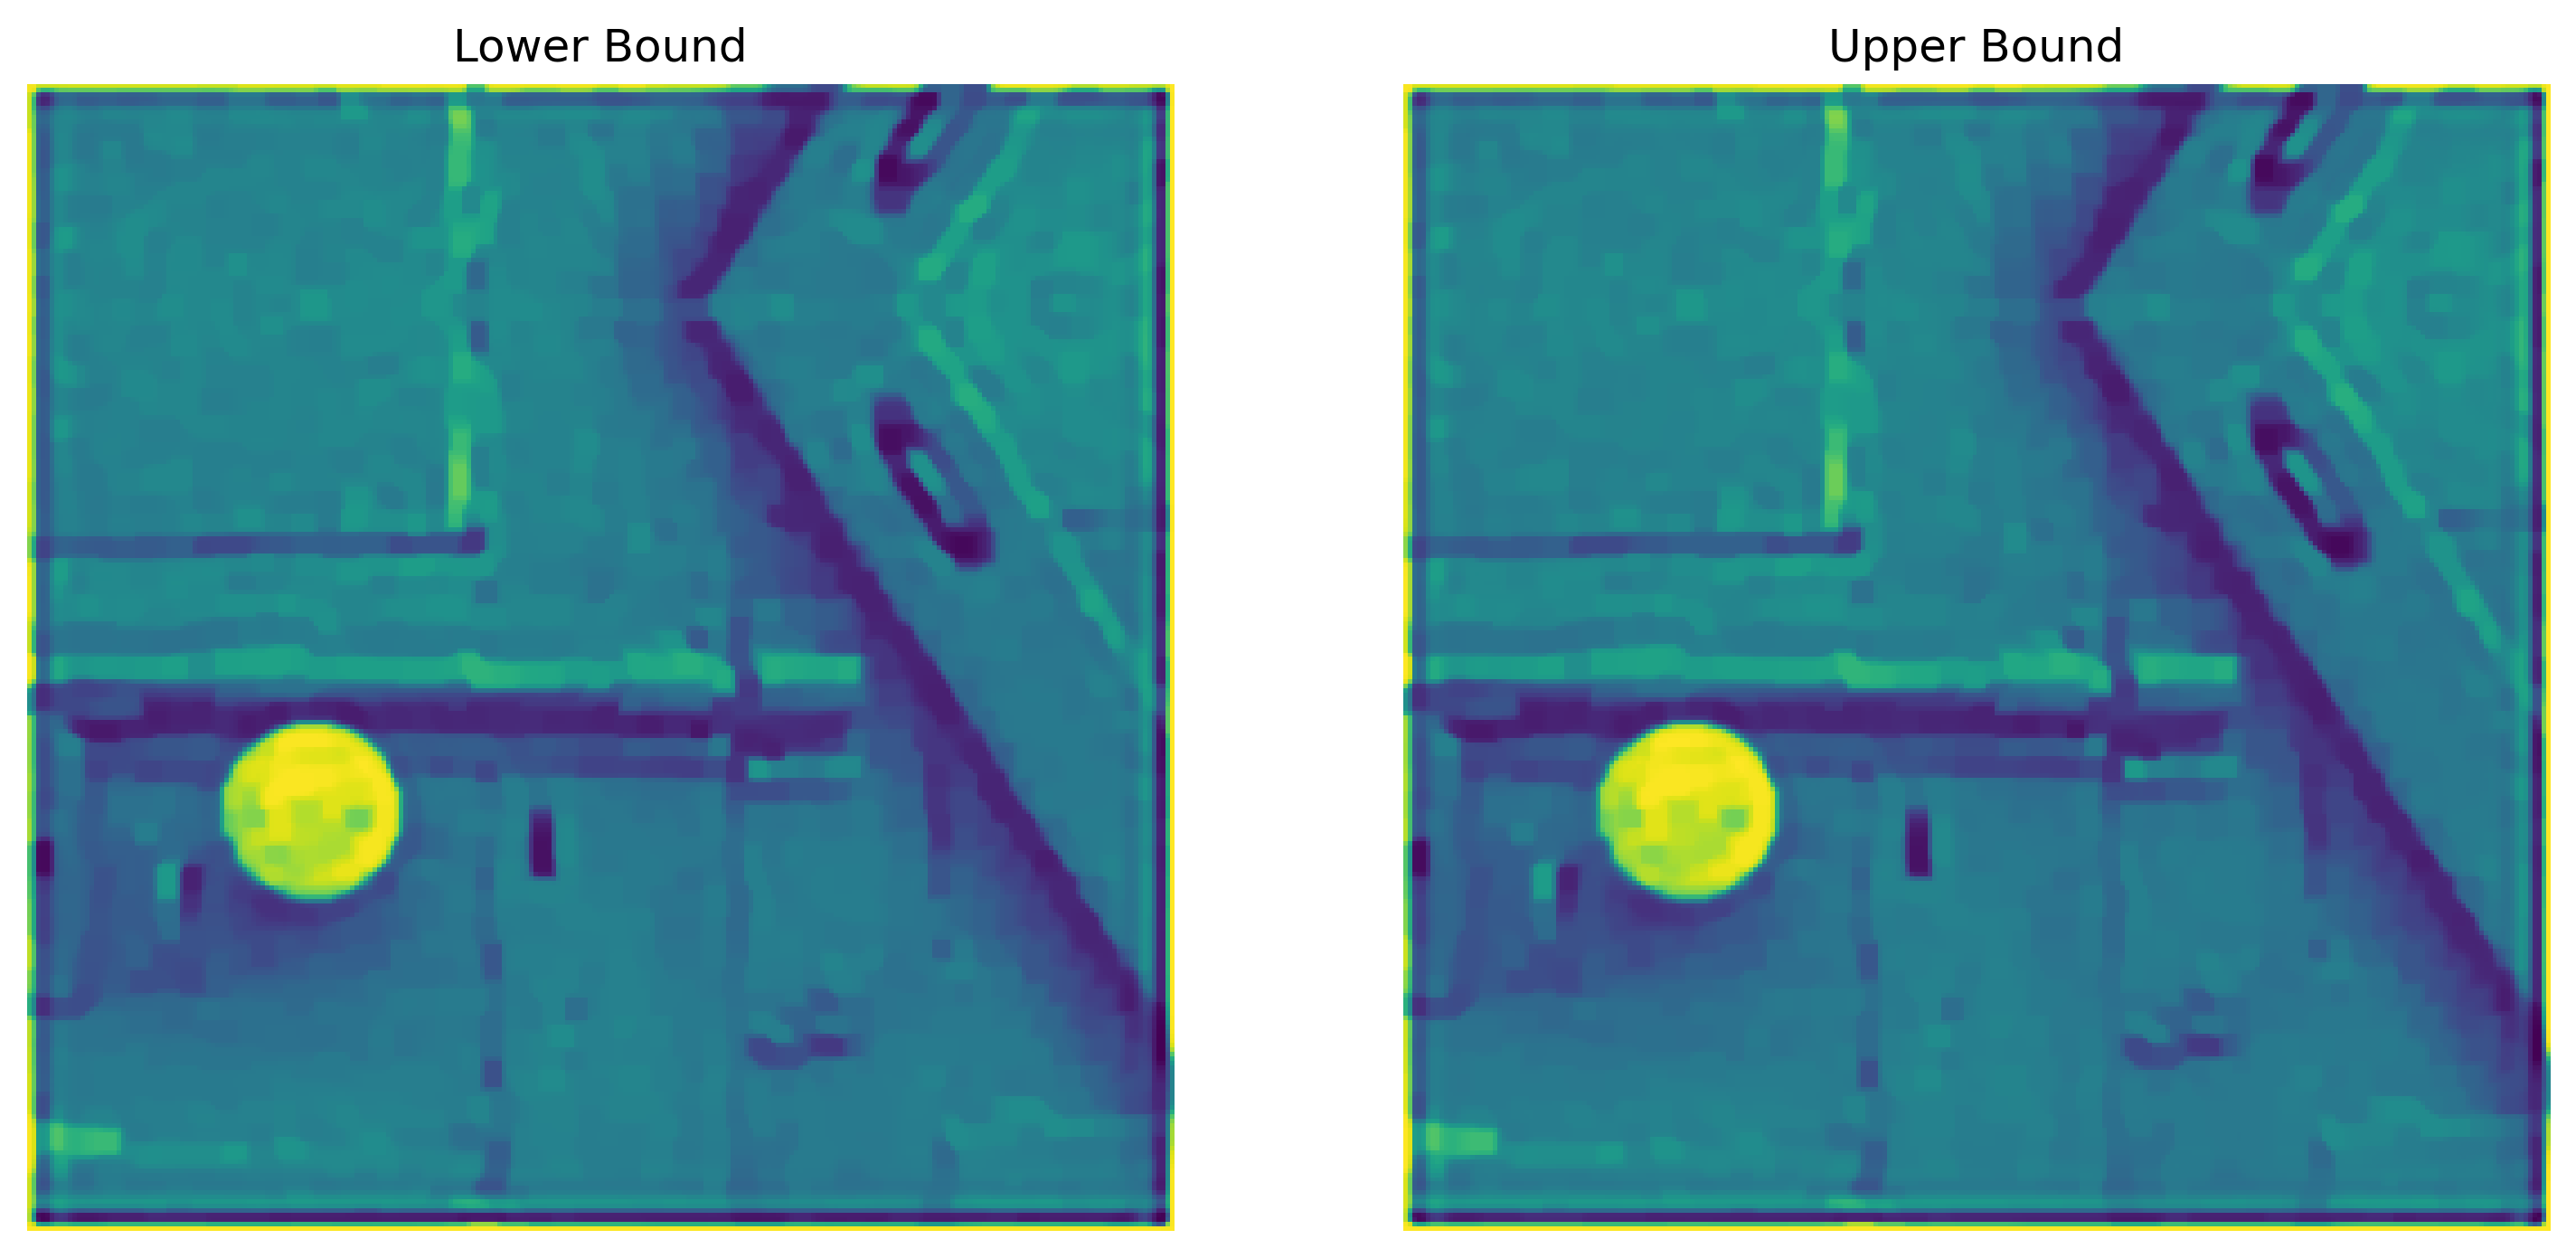

In [ ]:
plt.imshow(compute_pixel_mean(TENSOR))
plt.axis(False)
plt.title("T.V. Mean")
plt.show()

plt.imshow(compute_pixel_variance(TENSOR), vmin=0, vmax=200)
plt.colorbar()
plt.title("T.V. Variance")
plt.axis(False)
plt.show()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.set_dpi(300)
lower, upper = compute_pixel_confidence_intervals(TENSOR)
axs[0].imshow(lower)
axs[0].set_title("Lower Bound")
axs[0].axis(False)
axs[1].imshow(upper)
axs[1].set_title("Upper Bound")
axs[1].axis(False)
plt.show()